# Titanic - Class Prediction Project

## 1. (Business) Goal:
- Goal of this project is to be able to build a model which is able to predict the circumstances on which the passengers of the titanic survived or not.

## 2. Get Data
- I decided to get the data from seaborn to make sure other people can reproduce the same results on their device and herefore having access to the exact same dataset. The seaborn dataset looks mostly the same as the dataset given in the kaggle competition

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = sns.load_dataset('titanic')

In [4]:
# first taking a look at the first lines to make sure import worked as expected.
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### The columns `deck` and `age` seem to have a lot of missing values. The rest seems to be fine

In [6]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

## 3. Train/Test split
- Before I can split the dataset I want to make sure, that the data I pass makes sense. 
    - I have a lot of missing values in the `deck` column. I will drop this column as in imputation on this one may generate a lot of non-representant values.
    - For the same reason I will drop the `age` column. Also we do have information in the `who` column regarding if adult or child. This may be enough information to derive from an attribute as `age`
    - I will remove the `adult_male` column as it is only a filter for the `who` column returning `True` if it is a man.
    - The column `pclass` will also be removed, as we have the same information in the `class` column.
    - I will also drop the `alive` column as this is only a resemblance of the `survived` column. I will use the `survived` column as the column I want to predict
    - I will drop the `embark_town` column as it is redundant with the `embarked` column
- I decided to drop the 2 rows having `NaN` values on the `embarked` column as we probably wont suffer a lot data loss and keep things "real"

In [7]:
df.drop(labels=['deck', 'age', 'alive', 'embark_town', 'adult_male', 'pclass'], axis=1, inplace=True)

In [8]:
df.dropna(inplace=True)

In [9]:
y = df['survived']
# Passing the "cleaned" DataFrame with exception of the 'survived' column
X = df.drop('survived', axis=1)

In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((666, 8), (223, 8), (666,), (223,))

## 4. Explore the data
#### First I will assemble the train data together with its target to have a thorough exploration

In [11]:
fulltraindf = pd.concat([Xtrain, ytrain], axis=1)
fulltraindf.head()

,sex,sibsp,parch,fare,embarked,class,who,alone,survived
376,female,0,0,7.2500,S,Third,woman,True,1
458,female,0,0,10.5000,S,Second,woman,True,1
732,male,0,0,0.0000,S,Second,man,True,0
507,male,0,0,26.5500,S,First,man,True,1
830,female,1,0,14.4542,C,Third,child,False,1


<AxesSubplot:>

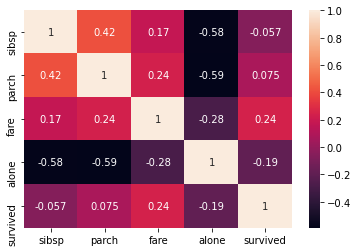

In [12]:
sns.heatmap(fulltraindf.corr(), annot=True)

Most of my columns are not highly correlated which is good. This means, that I don't have a any reason to drop another column due to redundance

#### 4.1 Survived vs. Not Survived

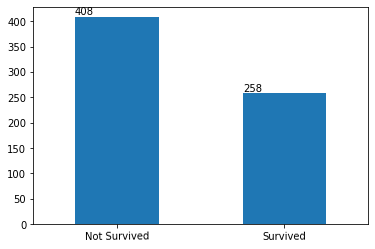

In [46]:
ax = fulltraindf['survived'].value_counts().plot(kind='bar', rot=0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Not Survived'
labels[1] = 'Survived'
ax.set_xticklabels(labels)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

We can see, that 408 people drowned, while 258 survived

#### 4.2 Class

<AxesSubplot:xlabel='class', ylabel='survived'>

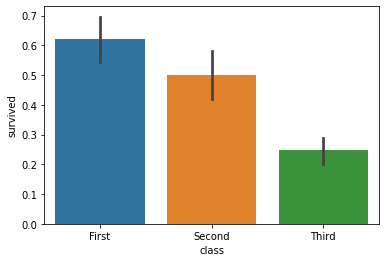

In [65]:
sns.barplot(data=fulltraindf, x='class', y='survived')

Here we see clearly, that being passenger of the first class clearly contributes to the chances of being a Titanic survivor

## 5. Feature Engineering

Let's take a look at our columns and differiantiate between categorical columns and numerical ones

Categorical:
- In the `sex` column we have "male" and "female" as categories.
- In the `embarked` column we have the ports in which the passengers boarded "S", "C" and "Q".
- In the `class` column we have "First", "Second" and "Third" class as categories.
- In the `who` column we have "woman", "man" and "child" as categories.
- Finally in the `alone` column  we have "True" and "False" as values describing if the passengers were in compandy of another passenger or not

Numerical:
- We have the `sibsp` column describing the amount of siblings or spouses for each passenger. The numbers range between 0 and 8
- The `parch` column describes how many parents/children the passenger has on board of the ship. These numbers range from 0 to 6
- Finally we have the `fare` column describing how much the passenger paid for their ticket. Thes numbers range between 0 and 512.3292

I decided to hot-encode all the categorical columns and run the MinMaxScaler on all numerical columns

In [20]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [21]:
trans = ColumnTransformer(
    (
        ('cat_preprocessing', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['sex', 'embarked', 'class', 'who', 'alone']),
        ('num_preprocessing', MinMaxScaler(), ['sibsp', 'parch', 'fare'])
    )
)

In [22]:
XtrainTrans = trans.fit_transform(Xtrain)
XtestTrans = trans.transform(Xtest)

# 6. Train Model
#### 6.1 Have a baseline Model
##### I decided to go with the DummyClassifier for the baseline modell

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
dm = DummyClassifier()

In [27]:
dm.fit(XtrainTrans, ytrain)

DummyClassifier()

In [28]:
dm.score(XtrainTrans, ytrain)

0.6126126126126126

#### 6.2 Train other models

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

I decided to run several models and use the VotingClassifier in order to select the one model with the best results

In [32]:
mlr = LogisticRegression()
mrf = RandomForestClassifier()
msv = SVC()
tree = DecisionTreeClassifier(max_depth=3)
models = [
    ('logreg', mlr),
    ('forest', mrf),
    ('svm', msv),
    ('tree', tree)
]

In [33]:
m = VotingClassifier(models)

In [34]:
m.fit(XtrainTrans, ytrain)

VotingClassifier(estimators=[('logreg', LogisticRegression()),
                             ('forest', RandomForestClassifier()),
                             ('svm', SVC()),
                             ('tree', DecisionTreeClassifier(max_depth=3))])

In [35]:
# Accuracy
m.score(XtrainTrans, ytrain), m.score(XtestTrans, ytest)

(0.8543543543543544, 0.8071748878923767)

The accuracy on the train data is 85% while on the test data it's lower - 80%. Let's proceed to optimization.

# 7. Optimization

#### Crossvalidation

In [38]:
from sklearn.model_selection import cross_val_score
import numpy as np

I will compare 4 performance metrics: `accuracy`, `precision`, `recall` and `f1`. I will create a DataFrame out of this `cross validation` in order to have a better overview of this metrics.

In [40]:
strings = [
    'accuracy',
    'precision',
    'recall',
    'f1'
]
cols = ['traintest', 'model', 'metric', 'mean', 'std']
traintest= [[XtrainTrans, ytrain], [XtestTrans, ytest]]
metricdf = pd.DataFrame(columns=cols)
for i in range(len(traintest)):
    if i == 0:
        trainortest = 'train'
    else:
        trainortest = 'test'
    for model in models:
        for metric in strings:
            result = cross_val_score(model[1], traintest[i][0], traintest[i][1], cv = 10, scoring=metric)
            row = {'traintest': trainortest, 'model': model[0], 'metric': metric, 'mean': round(np.mean(result), 3), 'std': round(np.std(result),5)}
            metricdf = metricdf.append(row, ignore_index=True)
    for metric in strings:
        result = cross_val_score(m, traintest[i][0], traintest[i][1], cv = 10, scoring=metric)
        row = {'traintest': trainortest, 'model': 'VotingClassifier', 'metric': metric, 'mean': round(np.mean(result), 3), 'std': round(np.std(result),5)}
        metricdf = metricdf.append(row, ignore_index=True)

In [41]:
metricdf

,traintest,model,metric,mean,std
0,train,logreg,accuracy,0.805,0.03339
1,train,logreg,precision,0.770,0.05865
2,train,logreg,recall,0.717,0.07931
3,train,logreg,f1,0.739,0.04852
4,train,forest,accuracy,0.821,0.04102
5,train,forest,precision,0.792,0.09202
6,train,forest,recall,0.748,0.06423
7,train,forest,f1,0.760,0.04740
8,train,svm,accuracy,0.815,0.02562
9,train,svm,precision,0.876,0.07042


Some people prefer to use the `classification_report` function for this overview, so I took the opportunity to display the results with this function too.

In [42]:
from sklearn.metrics import classification_report

In [43]:
allmodels = [
    mlr,
    mrf,
    msv,
    tree,
    m
]
for each in allmodels:
    for dataset in range(len(traintest)):
        if dataset == 0:
            trainortest = 'train'
        else:
            trainortest = 'test'
        each.fit(traintest[dataset][0], traintest[dataset][1])
        pred = each.predict(traintest[dataset][0])
        print(trainortest, str(type(each)).split('.')[-1].replace("'>", ""))
        print(classification_report(traintest[dataset][1], pred))

train LogisticRegression
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       408
           1       0.77      0.73      0.75       258

    accuracy                           0.81       666
   macro avg       0.81      0.80      0.80       666
weighted avg       0.81      0.81      0.81       666

test LogisticRegression
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       141
           1       0.75      0.73      0.74        82

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223

train RandomForestClassifier
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       408
           1       0.94      0.90      0.92       258

    accuracy                           0.94       666
   macro avg       0.94      0.93      0.93       

#### Using the classification report vs. cross_val_score
- With the cross_val_score it's easier to take a look at the model running with different sampling and several iterations.
    - Using some statistical methods on the result helps me understand the level of robustness of each model
        - It seems as if the level of robustness drops sigificantly with test/new data - This may be to the fact, that the test data set is smaller
- Using the classification report helps me understand at which scoring method the models seem to perform better than other
    - In train and test data the models seem to perform equally good